As a reminder of what we were doing, we were trying to find stationarity in the percent changes of securities so that we could make statistical assumptions on how a stock would trend in the future to ultimately build a filter for a long-short equity strategy.

Lots of big words in there so take a look at the following Quantopian Lectures because they break down these terms and ideas better than I can:

[Long-Short Equity](https://www.quantopian.com/lectures/long-short-equity)

[Integration, Cointegration, and Stationarity](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity)

In [1]:
# Let's start by importing some general libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.tsa.stattools import coint, adfuller
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import Latest
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar

In [2]:
# Our 'trading' universe will be limited to the top 1000 companies ranked by market cap
# We were originally attempting to filter by sector as well but that didn't go too well
# If you can figure out how to add a morningstar sector filter on the pipeline,
# let the team know because that would help give us a fundamental, economic reason for why the 
# algo should trade certain pairs of stocks if we decide to implement a Pairs Trading strategy
num_stocks = 1000
universe = Fundamentals.market_cap.latest.top(num_stocks)

# We'll look at the biggest companies back in 2012 so we have plenty of data to
# examine and perform testing on. We wouldn't want to do in-sample testing
top_securities_start_date = top_securities_end_date = '2012-01-01'

pipe = Pipeline(
    columns = {'market_cap':Fundamentals.market_cap.latest},
    screen=universe
)
pipeline_results = run_pipeline(pipe, top_securities_start_date, top_securities_end_date)

In [3]:
# Define our function which checks for stationarity
# Note that the cutoff is a fairly arbitrary number
def is_stationary(X, cutoff=0.001):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        # Series likely stationary
        return True
    else:
        # Series likely non-stationary
        return False

In [4]:
# Grab the security ids from pipeline results for simpler data access
security_ids = [equity[1].sid for equity in pipeline_results.index.values]

# Grab pricing data for, let's say one year
pricing_start_date = top_securities_start_date
pricing_end_date = '2012-12-31'
pricing = get_pricing(security_ids, fields='price', start_date=pricing_start_date, end_date=pricing_end_date)

# Get percent changes in price
pricing_pct_change = pricing.pct_change()[1:]

# Change column headers from equity objects to security ids, (again, for simpler data access)
pricing_pct_change.columns = security_ids

In [5]:
# Build list of securities which are stationary
stationary_security_ids = []

# If series doesn't converge, LinAlgError is thrown
# Note that it's bad form to catch all errors like this but for our purposes, its not a huge deal
try:
    for column in range(num_stocks):
        security_pricing_data = pricing_pct_change.iloc[:,column].values
        if(is_stationary(security_pricing_data)):
            stationary_security_ids.append(pricing_pct_change.columns[column])
except:
    pass

In [6]:
# Let's define our function that will perform linear regression and plot the results
def linreg(Y, X=None, graph=False):
    if X is None:
        X = list(range(len(Y)))
    # Running the linear regression using a simple ordinary least squares model
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    
    if graph:
        a = model.params[0]
        b = model.params[1]
        X = X[:, 1]
        # Return summary of the regression and plot results
        X2 = np.linspace(X.min(), X.max(), 100)
        Y_hat = X2 * b + a
        plt.scatter(X, Y, alpha=0.3) # Plot the raw data
        plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
        plt.xlabel('X Value')
        plt.ylabel('Y Value')
    
    # models.params[1] essentially describes how our series is trending
    # i.e. 0        --> no trend, horizontal movement
    #      negative --> downward movememt
    #      positive --> upward movement
    return model.params[1]

73.596917650650539

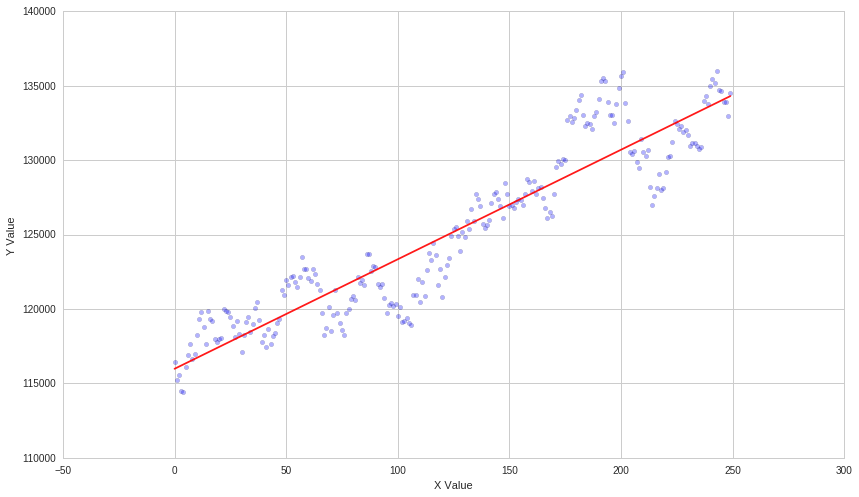

In [7]:
# Redo our benchmark metric from last time
# We want to find the trend of the cumalitive sum of the changes of the security
# As an example of why we want this instead of just the prices, let's take a look at Berkshire Hathaway
# which happens to be the 72nd security to pass our stationarity filtering
linreg(pricing[stationary_security_ids[71]].values, graph=True)

Our linear regression test is telling us that, on average, the underlying security moved 73.6 points per day, not 73.6% per day like we originally thought. Obviously, we need to change what we feed into our model. We actually want the cumulative sum of the daily percant change of the security to get the average % change per day. Let's redo this with BRK.A

BRK.A went up approximately 0.06153% per day, on average, from 2012-01-01 to 2012-12-31


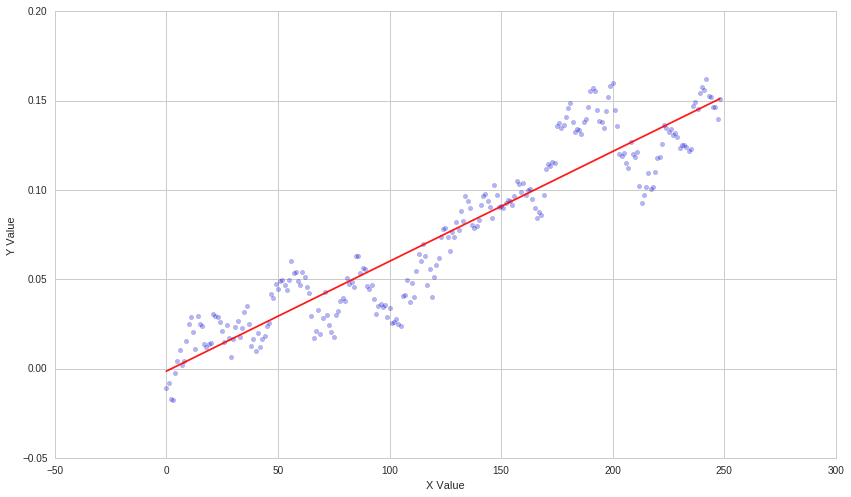

In [8]:
brk_trend = linreg(np.cumsum(pricing_pct_change[stationary_security_ids[71]]).values, graph=True)

print 'BRK.A went up approximately {}% per day, on average, from {} to {}'.format(round(brk_trend*100, 5), pricing_start_date, pricing_end_date)

That looks much better. Now our model accurately states that BRK.A is moving, on average, +.06% per day.

SPY went up approximately 0.04194% per day, on average, from 2012-01-01 to 2012-12-31


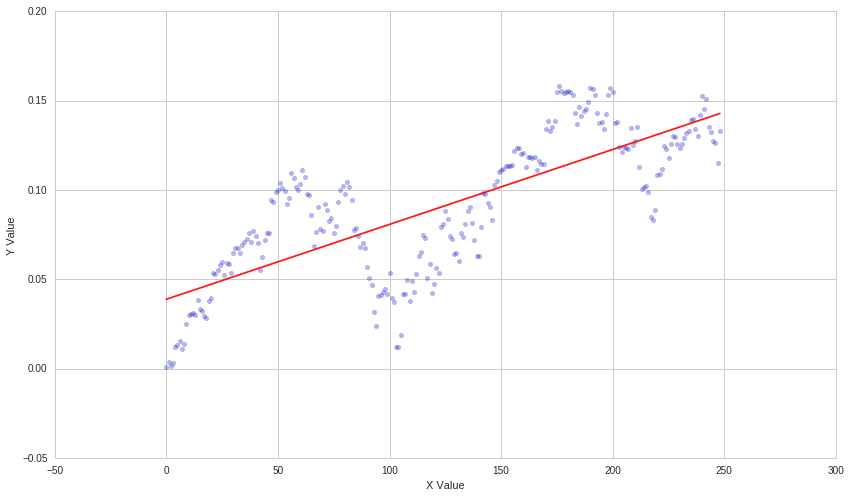

In [9]:
# Grab benchmark price data
benchmark = get_pricing('SPY', fields='price', start_date=pricing_start_date, end_date=pricing_end_date)
benchmark_pct_change = benchmark.pct_change()[1:]
benchmark_pct_change_cumsum = np.cumsum(benchmark_pct_change)

# See how our benchmark is trending
benchmark_trend = linreg(benchmark_pct_change_cumsum.values, graph=True)
print 'SPY went up approximately {}% per day, on average, from {} to {}'.format(round(benchmark_trend*100, 5), pricing_start_date, pricing_end_date)

The next step is to get the trend data on our stationary securities, long the ones with the highest positive trends, short the ones with the highest negative trends and see how well this strategy would perform over time. That of course assumes we're pursuing a momentum strategy - i.e. stocks that have performed well will keep performing well and stocks that are performing poorly will keep performing poorly. It would be worthwhile to test if the opposite is true - i.e. a mean reversion strategy.

In [10]:
num_stationary_securities = len(stationary_security_ids)
print 'In this time series, we have {} securities to analyze'.format(num_stationary_securities)

In this time series, we have 80 securities to analyze


In [11]:
# Compute cumulative sum of the percent changes of our stationary securities
stat_secs_pct_chng_cumsum = [
    np.cumsum(pricing_pct_change[stationary_security_ids[i]].values) for i in range(num_stationary_securities)
]

# Find the trend on that
stationary_trends = [
    linreg(stat_secs_pct_chng_cumsum[i]) for i in range(num_stationary_securities)
]

In [12]:
# For future use, let's create a dictionary with the security ids as keys and the trend as value
stationary_sids_trends = dict(zip(stationary_security_ids, stationary_trends))

Let's do a sanity check to make sure our values are actually correct. We'll check AAPL which has a security id of 24

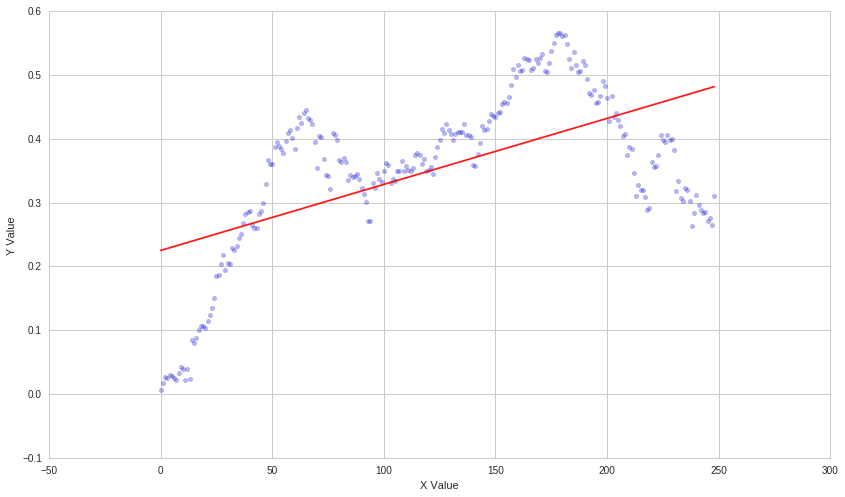

In [13]:
# Recalculate trend from scratch
aapl_pricing = get_pricing(24, fields='price', start_date=pricing_start_date, end_date=pricing_end_date)
aapl_pricing_pct_change = aapl_pricing.pct_change()[1:]
aapl_pct_change_cumsum = np.cumsum(aapl_pricing_pct_change)
aapl_trend = linreg(aapl_pct_change_cumsum.values, graph=True)

In [14]:
print 'According to our list comprehensions, AAPL grew {}% per day, on average, from {} to {}\n'.format(
    round(stationary_sids_trends[24]*100, 5), pricing_start_date, pricing_end_date)

print 'According to our "from scratch" calculation, AAPL grew {}% per day, on average, from {} to {}'.format(
    round(aapl_trend*100, 5), pricing_start_date, pricing_end_date)

According to our list comprehensions, AAPL grew 0.10354% per day, on average, from 2012-01-01 to 2012-12-31

According to our "from scratch" calculation, AAPL grew 0.10354% per day, on average, from 2012-01-01 to 2012-12-31


In [15]:
# Let's do a simple interest calculation to make sure our values align
# Interest = Principle * Interest Rate * Time
aapl_starting_price = aapl_pricing[0]
num_trading_days = len(aapl_pricing)
interest = aapl_starting_price * aapl_trend * num_trading_days
print 'Apple gained ${} from {} to {}'.format(
    aapl_pricing[-1] - aapl_pricing[0], pricing_start_date, pricing_end_date)

print 'Our simple interest calculation yields ${}'.format(round(interest, 3))

Apple gained $125.499 from 2012-01-01 to 2012-12-31
Our simple interest calculation yields $105.48


Obviously there are limitations with our method - it doesn't capture ALL price movements because it simplifies many data points to one number. 

The next thing to do is to see how well off we'd be by implementing our filter. We could do this by simply longing the highest n positive trends while shorting the highest n negative trends where n is the number of securities we'd like to long or short. I'd be very simple to do this in the research environment and see if our calculations hold over a few months - my thinking is that after about that much time, we'd need to recheck if our selected securities are still stationary because they may have fallen out of stationarity.

If we'd actually make money using this strategy, a good next step would be to implement a very simple holding algorithm in the backtest environment so we could take a closer look at the characteristics of our strategy like the associated Beta and Sharpe ratio. If that goes well, we'd send our strategy off to a Quantitative Developer team so they can check for stationary daily and update our holdings appropriately so we'd have an actual algorithm.

We're going to long the securities that not only beat the benchmark but that are also positive.
(Imagine if the benchmark was going down -10%, we wouldn't want to long a security just because it only went down -5%, we need it to be positive to make a profit.)
From the same reasoning, we're going to short the securities that have not only done worse than the benchmark, but that are also trending negatively.

In [16]:
long_sids = [ sid for sid, trend in stationary_sids_trends.items() if (trend > benchmark_trend and trend > 0) ]
short_sids = [ sid for sid, trend in stationary_sids_trends.items() if (trend < benchmark_trend and trend < 0) ]

num_long_sids = len(long_sids)
num_short_sids = len(short_sids)

print 'We have {} securities to long and {} securities to short \n'.format(num_long_sids, num_short_sids)
print 'Note that {} securities got filtered out because they performed worse than the benchmark but were still trending positively'.format(
    num_stationary_securities - num_long_sids - num_short_sids)

We have 36 securities to long and 29 securities to short 

Note that 15 securities got filtered out because they performed worse than the benchmark but were still trending positively


Let's see if our year's worth of in-sample data holds true for 3 months out.

Note that 3 months is a pretty arbitrary number. I'm just trying to get a sense of wheter our strategy has some merit.

In [17]:
# Let's see the % change in our 'portfolio' had we longed / shorted our securities starting at the end of our
# in-sample data and ending 3 months after that.
# i.e. in a way we're testing our method with three months of out of sample data

oos_start_date = '2013-01-01'  
oos_end_date = '2013-03-31'   
oos_long_prices = get_pricing(long_sids, fields='price', start_date=oos_start_date, end_date=oos_end_date)
oos_short_prices = get_pricing(short_sids, fields='price', start_date=oos_start_date, end_date=oos_end_date)
oos_benchmark_prices = get_pricing('SPY', fields='price', start_date=oos_start_date, end_date=oos_end_date)

In [18]:
# The values in the first row and all the columns are our starting prices
oos_long_prices_start = oos_long_prices.iloc[1,:].values.tolist()
# The values in the last row and all the columns are our ending prices
oos_long_prices_end = oos_long_prices.iloc[-1,:].values.tolist()

# Similiar thing with our shorts
oos_short_prices_start = oos_short_prices.iloc[1,:].values.tolist()
oos_short_prices_end = oos_short_prices.iloc[-1,:].values.tolist()

# And don't forget the benchmark to compare to
oos_benchmark_price_start = oos_benchmark_prices.values[0]
oos_benchmark_price_end = oos_benchmark_prices.values[-1]

In [19]:
# This is a very simple analysis, but one way to calculate profit is this:
# Profit =   (total_val_of_longs_end - total_val_of_longs_start) 
#          + (total_val_of_shorts_start - total_val_of_shorts_end)
# We'll get this as a % to compare to the market

oos_long_start_val = sum(oos_long_prices_start)
oos_long_end_val = sum(oos_long_prices_end)
oos_short_start_val = sum(oos_short_prices_start)
oos_short_end_val = sum(oos_short_prices_end)

oos_profit_long = oos_long_end_val - oos_long_start_val
oos_profit_short = oos_short_start_val - oos_short_end_val
oos_profit_total = oos_profit_long + oos_profit_short

oos_amount_invested_start = oos_long_start_val + oos_short_start_val
oos_pct_change = ( oos_profit_total / oos_amount_invested_start ) * 100

benchmark_pct_change = (( oos_benchmark_price_end - oos_benchmark_price_start ) / oos_benchmark_price_start) * 100

print 'We gained {}% returns over 3 months compared to the benchmark which gained {}%'.format(
    round(oos_pct_change, 3), round(benchmark_pct_change, 3))

We gained 11.245% returns over 3 months compared to the benchmark which gained 7.665%


So our hypothesis does seem to hold some weight. It would be interesting to see if our data from 2012 to 2013 is predictive for a whole year out. We also need to do more complex analysis, such as seeing the volatility in our selected securities. There are ways to do this in the Research environment but a good way to get an overview would be to implement this strategy in a simple backtest which calculates the relevant metrics for us.

To implement a simple holding strategy, we could easily transfer the relevant sids that we found on here to the backtesting environment by simply copy-pasting the long and short security ids. Here they are:

In [20]:
print long_sids
print short_sids

[903, 1161, 780, 963, 24, 154, 157, 410, 161, 679, 939, 812, 559, 438, 1097, 185, 700, 1091, 62, 821, 338, 1274, 734, 353, 357, 766, 465, 239, 368, 753, 114, 822, 630, 916, 122, 1228]
[128, 448, 2, 1057, 273, 660, 661, 538, 166, 168, 754, 1251, 1267, 607, 64, 67, 197, 455, 328, 460, 337, 1209, 216, 858, 351, 739, 1131, 629, 938]
